In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image, ImageDraw

In [2]:
# modify the dir 

data_path_dir = 'E:\DataSets\CKPlus\cohn-kanade-images'
label_path_dir = 'E:\DataSets\CKPlus\FACS_labels\FACS'
landmark_path_dir = 'E:\DataSets\CKPlus\Landmarks\Landmarks'

In [39]:
def get_reserved_set(label_path_dir):
    au_label = []
    returned_label = []
    for names in os.listdir(label_path_dir):
        name = os.path.join(label_path_dir, names)
        for sequences in os.listdir(name):
            sequence = os.path.join(name, sequences)
            if os.listdir(sequence):
                temp = np.loadtxt(os.path.join(sequence, os.listdir(sequence)[-1]))
                if temp.ndim == 1:
                    au_label.append(temp.astype(np.int32))
                    returned_label.append(temp[0].astype(np.int32))
                elif temp.ndim == 2:
                    au_label.extend(temp.astype(np.int32))
                    returned_label.append(temp[:, 0].astype(np.int32))
                else:
                    print(temp)
                    raise Exception("label info error!")
    ll = []
    for au in au_label:
        if au.ndim == 2:
            ll.extend(au[:, 0].astype(np.int32))
        elif au.ndim == 1:
            ll.append(au[0].astype(np.int32))
        else:
            print(au)
            raise Exception("label info error!")
    label_set = set(ll)
    reserved_set = set()
    for label in label_set:
        if ll.count(label) > 35:
            reserved_set.add(label)
    return reserved_set, returned_label  # (1, 2, 4, 5, 6, 7, 9, 12, 14, 15, 17, 20, 23, 24, 25, 26, 27)

def convert_label(init_label, reserved_set):
    reserved_list = list(reserved_set)
    converted_label = [0] * len(reserved_set)
    if type(init_label) == list:
        for l in init_label:
            for i in range(len(reserved_list)):
                if l == reserved_list[i]:
                    converted_label[i] = 1
    elif type(init_label) == int:
        for i in range(len(reserved_list)):
            if init_label == reserved_list[i]:
                converted_label[i] = 1
    else:
        print("init label is not a list! '", init_label, "'")
        print("type is", type(init_label))
        raise Exception

    return converted_label

In [35]:
reserved_set, returned_label = get_reserved_set(label_path_dir)

In [44]:
convert_label(26, reserved_set)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

In [3]:
def get_label(label_path_dir):
    au_label = []
    returned_label = []
    for names in os.listdir(label_path_dir):
        name = os.path.join(label_path_dir, names)
        for sequences in os.listdir(name):
            sequence = os.path.join(name, sequences)
            if os.listdir(sequence):
                temp = np.loadtxt(os.path.join(sequence, os.listdir(sequence)[-1]))
                if temp.ndim == 1:
                    au_label.append(temp.astype(np.int32))
                    returned_label.append(temp[0].astype(np.int32))
                elif temp.ndim == 2:
                    au_label.extend(temp.astype(np.int32))
                    returned_label.append(temp[:, 0].astype(np.int32))
                else:
                    print(temp)
                    raise Exception("label info error!")
    return au_label

In [4]:
au_label = get_label(label_path_dir)

# Label preprocess

AU1: 177
AU2: 117
AU4: 194
AU5: 102
AU6: 123
AU7: 121
AU9: 75
AU10: 21
AU11: 34
AU12: 131
AU13: 2
AU14: 37
AU15: 94
AU16: 24
AU17: 202
AU18: 9
AU20: 79
AU21: 3
AU22: 4
AU23: 60
AU24: 58
AU25: 324
AU26: 50
AU27: 81
AU28: 1
AU29: 2
AU30: 2
AU31: 3
AU34: 1
AU38: 29
AU39: 16
AU43: 9
AU44: 1
AU45: 17
AU54: 2
AU61: 1
AU62: 2
AU63: 2
AU64: 4


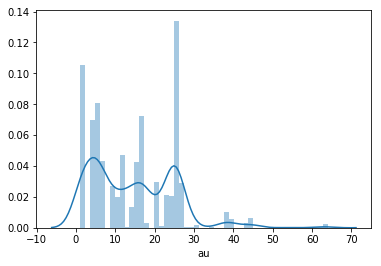

In [5]:
ll = []
for au in au_label:
    if au.ndim == 2:
        ll.extend(au[:, 0].astype(np.int32))
    elif au.ndim == 1:
        ll.append(au[0].astype(np.int32))
    else:
        print(au)
        raise Exception("label info error!")
label_set = set(ll)
reserved_set = set()
for label in label_set:
    print('AU'+str(label)+': '+str(ll.count(label)))

ll = pd.DataFrame(ll, columns=['au'])
sns.distplot(ll['au'], bins=50)

# AU image preprocess

In [32]:
def load_au_image_from_path(data_path_dir):
    # prepare au image
    au_image = []
    for names in os.listdir(data_path_dir):
        name = os.path.join(data_path_dir, names)
        for sequences in os.listdir(name):
            sequence = os.path.join(name, sequences)
            if os.path.isdir(sequence):
                if os.listdir(sequence):
                    au_image.append(
                        Image.open(os.path.join(sequence, os.listdir(sequence)[-1])).convert('RGB'))
    return au_image

def load_au_landmark_from_path(landmark_path_dir):
    au_landmark = []
    for names in os.listdir(landmark_path_dir):
        name = os.path.join(landmark_path_dir, names)
        for sequences in os.listdir(name):
            sequence = os.path.join(name, sequences)
            if os.listdir(sequence):
                au_landmark.append(np.loadtxt(os.path.join(sequence, os.listdir(sequence)[-1])))
    return au_landmark

def draw_landmark_point(img, landmark):
    draw = ImageDraw.Draw(img)
    t = 1
    for point in landmark:
        draw.text(point.tolist(), str(t), fill=255)
        t += 1
    return img
    
def crop_au_img(img, landmark):
    width, height = img.size
    left = max(int(min(landmark[:, 0])) - 10, 0)
    right = min(width, int(max(landmark[:, 0] + 10)))
    top = max(int(min(landmark[:, 1])) - 30, 0)
    bottom = min(height, int(max(landmark[:, 1])) + 10)
    img = img.crop((left, top, right, bottom))
    return img

In [7]:
au_image = load_au_image_from_path(data_path_dir)
au_landmark = load_au_landmark_from_path(landmark_path_dir)

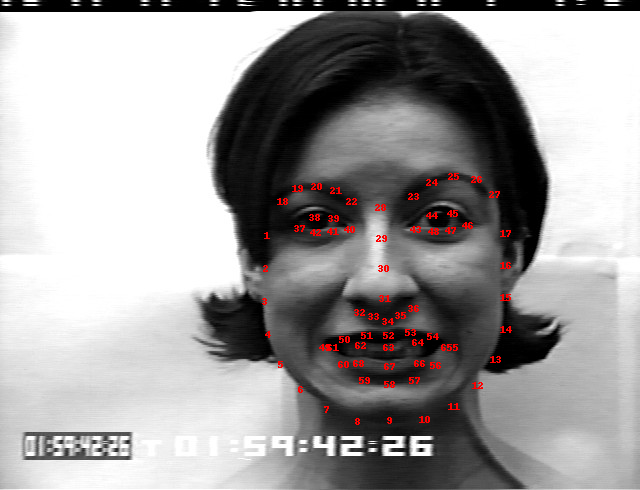

In [29]:
index = 1
img = draw_landmark_point(au_image[index], au_landmark[index])
img

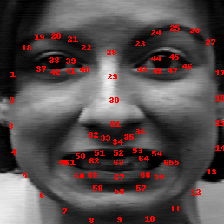

In [49]:
crop_au_img(au_image[index], au_landmark[index]).resize((224,224))